In [4]:
%pip install folium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster

data = pd.read_csv('../cloud-data/bus_data_modified.csv')
data.head()

,id,name,type,calculatedCourse,routeName,created,longitude,latitude,paxLoad,totalCap,more,deviceId,routeBlockId,timestamp,load,stop
0,4855,4131,Transit Bus,212.735226,LX Route,02:23 PM,-74.433571,40.519749,0,67,101,402213,111417,2024-10-31 18:24:00,0.000000,Quads
1,4859,4177,Transit Bus,128.232575,LX Route,02:23 PM,-74.436304,40.524327,27,67,102,402325,111417,2024-10-31 18:24:00,0.402985,Livingston Student Center
2,4873,4191,Transit Bus,240.802514,B Route,02:23 PM,-74.457712,40.523463,8,67,101,402329,113278,2024-10-31 18:24:00,0.119403,NaN
3,4876,4194,Transit Bus,299.246496,B Route,02:23 PM,-74.438946,40.521624,4,67,102,402330,113250,2024-10-31 18:24:00,0.059701,NaN
4,17624,4002,Heavy Duty Transit LF,226.694476,REXB Route,02:23 PM,-74.438830,40.483538,2,68,102,402643,112511,2024-10-31 18:24:00,0.029412,NaN


In [6]:
# convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
# shift all timestamps 6 hrs back
data['timestamp'] = data['timestamp'] - pd.Timedelta(hours=4)

data['load'] = data['paxLoad'] / data['totalCap']
# only use the latitude and longitude columns between certain values
data = data[(data['latitude'] > 40.4) & (data['latitude'] < 40.53)]
data = data[(data['longitude'] > -74.5) & (data['longitude'] < -74.3)]
data.head()

,id,name,type,calculatedCourse,routeName,created,longitude,latitude,paxLoad,totalCap,more,deviceId,routeBlockId,timestamp,load,stop
0,4855,4131,Transit Bus,212.735226,LX Route,02:23 PM,-74.433571,40.519749,0,67,101,402213,111417,2024-10-31 14:24:00,0.000000,Quads
1,4859,4177,Transit Bus,128.232575,LX Route,02:23 PM,-74.436304,40.524327,27,67,102,402325,111417,2024-10-31 14:24:00,0.402985,Livingston Student Center
2,4873,4191,Transit Bus,240.802514,B Route,02:23 PM,-74.457712,40.523463,8,67,101,402329,113278,2024-10-31 14:24:00,0.119403,NaN
3,4876,4194,Transit Bus,299.246496,B Route,02:23 PM,-74.438946,40.521624,4,67,102,402330,113250,2024-10-31 14:24:00,0.059701,NaN
4,17624,4002,Heavy Duty Transit LF,226.694476,REXB Route,02:23 PM,-74.438830,40.483538,2,68,102,402643,112511,2024-10-31 14:24:00,0.029412,NaN


KeyboardInterrupt: 

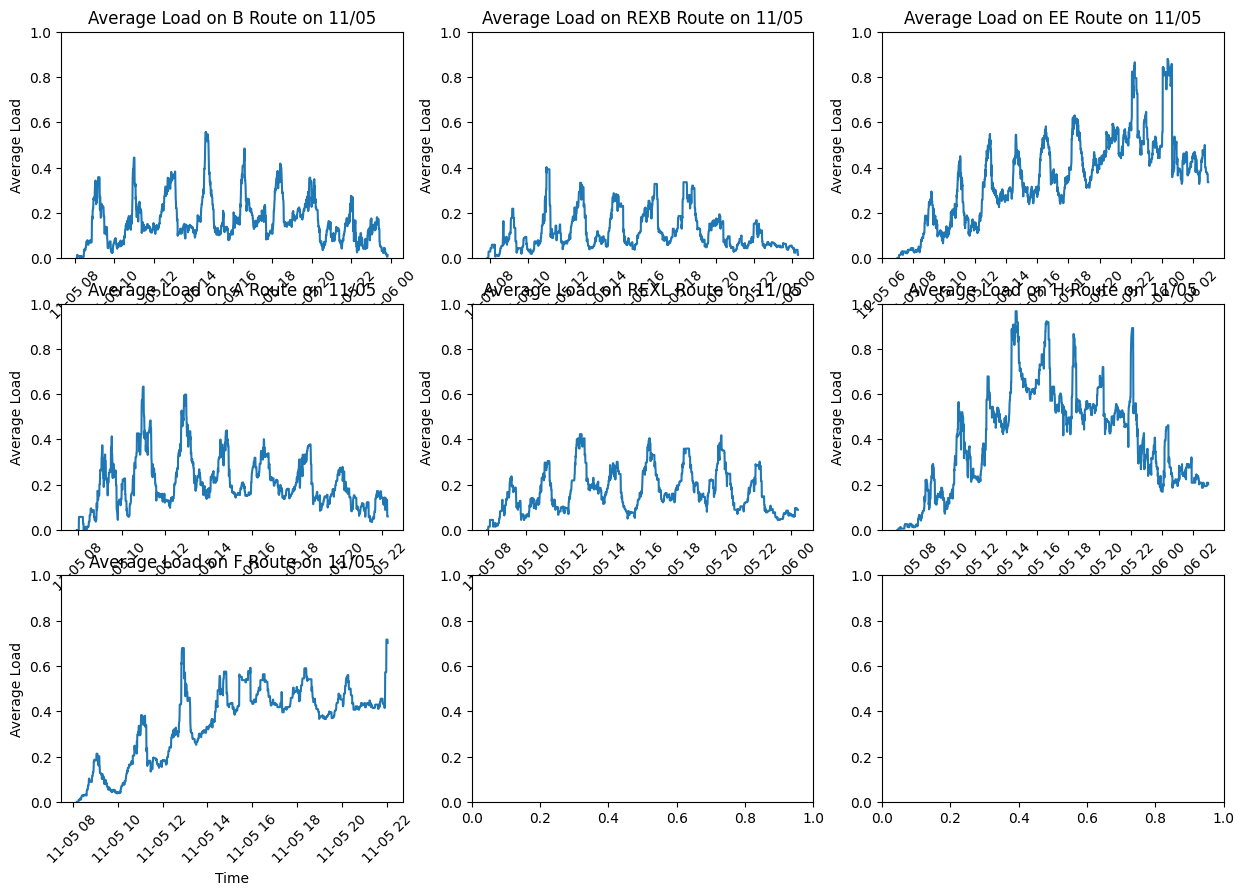

In [7]:
# Filter data for the relevant time range
data_time = data[(data['timestamp'] > '2024-11-05 6:00') & (data['timestamp'] < '2024-11-06 3:00')]

# Create a 3x3 grid for plots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()  # Flatten to easily index into the grid

# Initialize subplot index
plot_idx = 0

for route in data['routeName'].unique():
    # Skip LX and Weekend routes
    if 'LX' in route or 'Weekend' in route: continue
    
    # Filter data for the current route
    data_route = data_time[data_time['routeName'] == route]
    
    # Compute average load at each timestamp
    timestamps = data_route['timestamp'].dt.floor('s').unique()
    load = [data_route[data_route['timestamp'].dt.floor('s') == timestamp]['load'].mean() for timestamp in timestamps]
    
    # Plot only if there's space in the grid
    if plot_idx < len(axes):
        ax = axes[plot_idx]
        ax.plot(timestamps, load)
        ax.set_title(f'Average Load on {route} on 11/05')
        ax.set_xlabel('Time')
        ax.set_ylabel('Average Load')
        ax.set_ylim(0, 1)  # Set x-axis limit
        ax.tick_params(axis='x', rotation=45)
        plot_idx += 1
    else:
        break  # Stop if grid is full

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

(0.0, 29.925)

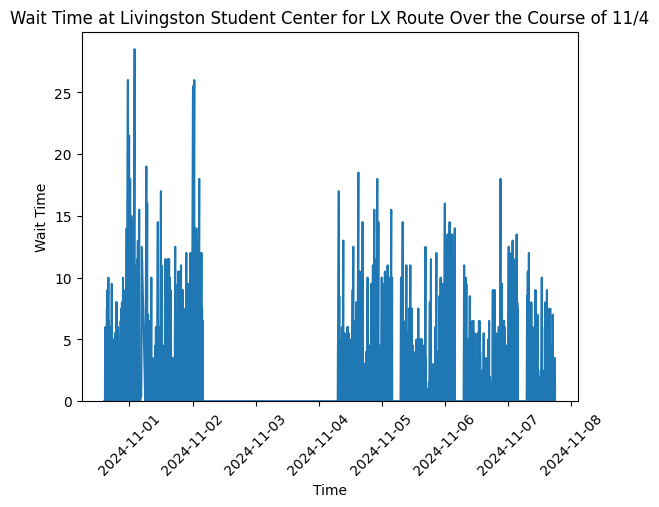

In [8]:
# for a given route and stop create a graph for the wait time to catch the next bus
route = 'LX Route'
stop = 'Livingston Student Center'
date_first = '10-31'
date_end = '11-08'

# limit the data to one day
data_time = data[(data['timestamp'] >= f'2024-{date_first}') & (data['timestamp'] < f'2024-{date_end}')]
data_route = data_time[data_time['routeName'] == route]
data_stop = data_route[data_route['stop'] == stop]

# get the wait time at each timestamp
timestamps = data_time['timestamp'].dt.floor('s').unique()
wait = [0]
longest = []
for timestamp in timestamps:
    if len(data_route[data_route['timestamp'].dt.floor('s') == timestamp]) == 0:
        if wait[-1] != 0: longest.append([timestamp, wait[-1]])
        wait.append(0)
        continue

    if len(data_stop[data_stop['timestamp'].dt.floor('s') == timestamp]) >= 1:
        if wait[-1] != 0: longest.append([timestamp, wait[-1]])
        wait.append(0)
    else:
        wait.append(0.5 + wait[-1])

# remove the first element
wait = wait[1:]

plt.plot(timestamps, wait)
plt.xticks(rotation=45)
plt.title(f'Wait Time at {stop} for {route} Over the Course of 11/4')
plt.xlabel('Time')
plt.ylabel('Wait Time')
plt.ylim(0)


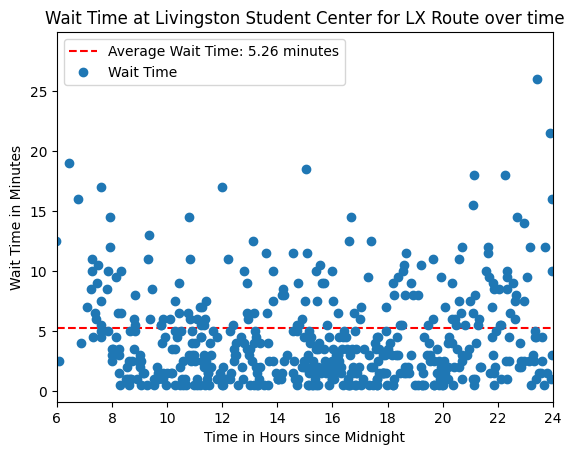

In [9]:
longest = pd.DataFrame(longest, columns=['timestamp', 'wait'])

# remove all the wait times that are more than 80 minutes
longest = longest[longest['wait'] < 80]

longest['time'] = longest['timestamp'].dt.time
# convert time to a number
longest['time'] = longest['time'].apply(lambda x: x.hour + x.minute / 60)

average = longest['wait'].mean()

# draw a dotted line at the average wait time
plt.axhline(y=average, color='r', linestyle='--')

# plot the longest wait times with the time
plt.plot(longest['time'], longest['wait'], 'o')

plt.xlim(6, 24)

plt.legend(['Average Wait Time: ' + str(round(average, 2)) + ' minutes', 'Wait Time'])

plt.title(f'Wait Time at {stop} for {route} over time')
plt.xlabel('Time in Hours since Midnight')
plt.ylabel('Wait Time in Minutes')

plt.show()

C:\Users\akash\AppData\Local\Temp\ipykernel_2496\57733110.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([interval['wait'] for interval in intervals], labels=[f'{i} - {i+2}' for i in range(6, 24, 2)])


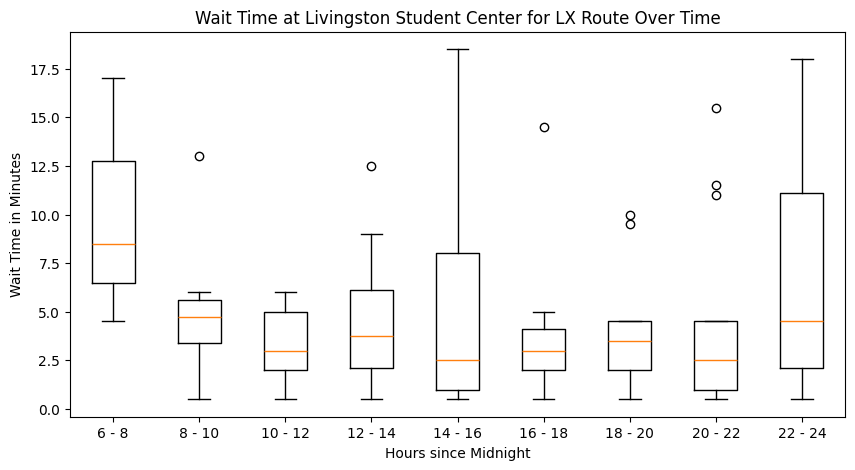

In [17]:
# create a box plot of the wait times in 2 hour intervals
# for example get all the data between 6-8 and 8-10 and so on
# create box plots for each of the intervals
intervals = []

for i in range(6, 24, 2):
    start = pd.Timestamp(f'2024-11-04 00:00:00') + pd.Timedelta(hours=i)
    end = pd.Timestamp(f'2024-11-04 00:00:00') + pd.Timedelta(hours=i+2)
    data_interval = longest[(longest['timestamp'] >= start) & (longest['timestamp'] < end)]
    if len(data_interval) > 0:
        intervals.append(data_interval)
    else:
        intervals.append(pd.DataFrame(columns=['timestamp', 'wait']))

# create a box plot for each interval
plt.figure(figsize=(10, 5))
plt.boxplot([interval['wait'] for interval in intervals], labels=[f'{i} - {i+2}' for i in range(6, 24, 2)])
plt.title(f'Wait Time at {stop} for {route} Over Time')
plt.xlabel('Hours since Midnight')
plt.ylabel('Wait Time in Minutes')
plt.xticks(rotation=0)
plt.show()

In [10]:
sum(wait) / len(wait)

1.7275489733301865

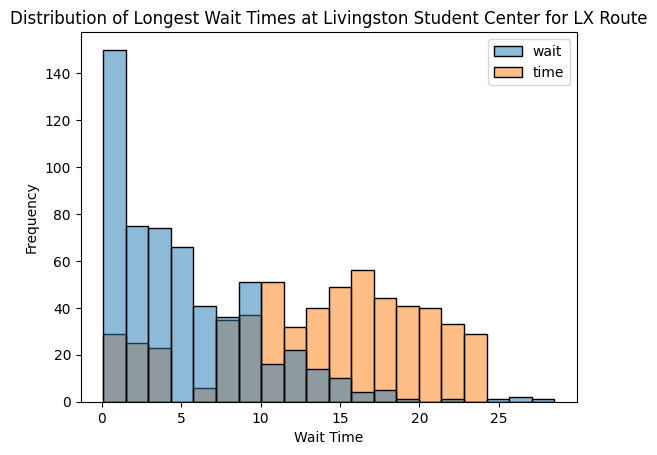

In [11]:
# graph the distribution of longest
sns.histplot(longest, bins=20)
plt.title(f'Distribution of Longest Wait Times at {stop} for {route}')
plt.xlabel('Wait Time')
plt.ylabel('Frequency')
plt.show()